In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import RFE, RFECV, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
wines_path:str= r"https://docs.google.com/spreadsheets/d/e/2PACX-1vTH3jye4YrhpWRVtWivYX0fxP9VsyXhGxGqTeJ-_LVVxKAuF0xAHImhsLMSwXUi4fRcBP0ETEVZtVRf/pub?output=csv"

In [3]:
df = pd.read_csv(wines_path)

In [4]:
print("ANÁLISIS INICIAL DEL DATASET")

# Información básica
print(f"Dimensiones del dataset: {df.shape}")
print(f"\nPrimeras 5 filas:")
df.head()


ANÁLISIS INICIAL DEL DATASET
Dimensiones del dataset: (1599, 12)

Primeras 5 filas:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:

print(f"\nInformación del dataset:")
df.info()



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [6]:
print(f"\nEstadísticas descriptivas:")
df.describe().T



Estadísticas descriptivas:


,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [7]:
print(f"\nValores nulos por columna:")
df.isnull().sum()


Valores nulos por columna:


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [8]:
# Verificar si hay variables categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"\nColumnas categóricas: {list(categorical_cols)}")



Columnas categóricas: []


In [9]:
# Preparar los datos
def prepare_data(df:pd.DataFrame, target:str = "target"):
    """Preparar datos para feature selection"""
    df_clean = df.copy()
    
    if df_clean.isnull().sum().sum() > 0:
        print("Manejar valores nulos")
        # Para características numéricas
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())
        
        # Para características categóricas
        categorical_cols = df_clean.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0] if not df_clean[col].mode().empty else 'Unknown')
    
    # Codificar variables categóricas
    label_encoders = {}

    for col in df_clean.select_dtypes(include=['object']).columns:
        print("Evitar codificar la variable objetivo si es categórica")
        if col != target: 

            le = LabelEncoder()
            df_clean[col] = le.fit_transform(df_clean[col].astype(str))
            label_encoders[col] = le
    
    return df_clean


In [10]:
df.quality.unique()

array([5, 6, 7, 4, 8, 3])

In [11]:
target_column = "quality"

In [12]:
# Preparar datos
df_processed = prepare_data(df,target_column)
df_processed.sample()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
170,7.9,0.885,0.03,1.8,0.058,4.0,8.0,0.9972,3.36,0.33,9.1,4


In [13]:
# Separar características y variable objetivo
X = df_processed.drop(columns=[target_column])
y = df_processed[target_column]

# Si la variable objetivo es categórica, codificarla
if y.dtype == 'object':
    le_target = LabelEncoder()
    y = le_target.fit_transform(y)
    print(f"Variable objetivo codificada. Clases: {le_target.classes_}")

print(f"\nCaracterísticas: {X.shape[1]}")
print(f"Tamaño del dataset: {X.shape[0]} muestras")
print(f"Distribución de la variable objetivo: {pd.Series(y).value_counts().to_dict()}")


Características: 11
Tamaño del dataset: 1599 muestras
Distribución de la variable objetivo: {5: 681, 6: 638, 7: 199, 4: 53, 8: 18, 3: 10}


In [14]:
# Escalar características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

*Recursive Feature Elimination (RFE) con Validación Cruzada*
---

In [15]:
models = {
    # Modelos de manera aleatoria para uso de ver que es mas conveniente de manera random
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
}


# **Feature Selection: Explicación Sencilla**

## **RFE (Recursive Feature Elimination) - "Eliminación hacia Atrás Inteligente"**

### **¿Cómo funciona?**
Imagina que estás preparando una mochila para un viaje:

1. **Empiezas con todas tus cosas** (todas las características)
2. **Vas probando** qué pasa si sacas cada cosa
3. **Eliminas lo que menos afecta** (la característica menos importante)
4. **Repites** el proceso hasta quedarte con lo esencial

### **Proceso paso a paso:**
```
Todas las características → Modelo → Identifica la menos importante → Elimina → Repite
```

### **Ejemplo práctico:**
**Predecir precio de casas:**
- Empiezas con: tamaño, habitaciones, baños, garage, jardín, piscina
- El modelo dice: "piscina" es lo menos importante
- Eliminas piscina
- Repites: ahora "jardín" es lo menos importante
- Eliminas jardín
- Te quedas con: tamaño, habitaciones, baños, garage

### **Ventaja:**
- Elimina características de forma inteligente
- Se enfoca en lo que realmente importa

---

## **Forward Selection - "Construcción desde Cero"**

### **¿Cómo funciona?**
Como armar un equipo de fútbol empezando desde cero:

1. **Empiezas con equipo vacío** (ninguna característica)
2. **Pruebas cada jugador individualmente** (cada característica sola)
3. **Agregas al mejor jugador** (la característica que más mejora el modelo)
4. **Repites** buscando quién complementa mejor al equipo

### **Proceso paso a paso:**
```
Característica vacía → Prueba cada una → Agrega la mejor → Prueba combinaciones → Repite
```

### **Ejemplo práctico:**
**Predecir si un cliente comprará:**
- Pruebas individual: "edad" → buen resultado
- Pruebas individual: "ingresos" → mejor resultado
- Agregas "ingresos" (la mejor)
- Ahora pruebas: "ingresos + edad", "ingresos + historial", "ingresos + ubicación"
- "ingresos + historial" da mejor resultado → agregas historial
- Continuas...

### **Ventaja:**
- No pierdes características importantes
- Computacionalmente más eficiente al empezar con pocas

---

## **Backward Elimination - "Limpieza General"**

### **¿Cómo funciona?**
Como limpiar tu closet:

1. **Tienes toda la ropa** (todas las características)
2. **Ves qué prenda usas menos** (característica menos útil)
3. **La sacas del closet** (eliminas)
4. **Verificas** si todavía puedes vestirte bien
5. **Repites** hasta quedarte con lo esencial

### **Proceso paso a paso:**
```
Todas las características → Elimina la menos importante → Verifica rendimiento → Repite
```

### **Ejemplo práctico:**
**Diagnosticar una enfermedad:**
- Tienes: fiebre, tos, dolor cabeza, cansancio, estornudos, dolor muscular
- El modelo dice: "estornudos" es lo menos relevante
- Eliminas estornudos
- Ahora: "dolor cabeza" es lo menos relevante
- Eliminas dolor cabeza
- Te quedas con: fiebre, tos, cansancio, dolor muscular

### **Ventaja:**
- Menos riesgo de perder combinaciones importantes
- Bueno cuando tienes muchas características

---

## **Comparación Sencilla**

| Método | Analogía | Cuándo usar | Velocidad |
|--------|----------|-------------|-----------|
| **RFE** | Eliminar lo menos útil de tu mochila | Cuando quieres selección automática | 🟡 Media |
| **Forward** | Construir equipo desde cero | Cuando tienes muchas características | 🟢 Rápido al inicio |
| **Backward** | Limpiar closet lleno | Cuando tienes pocas características | 🔴 Lento al inicio |

---

## **¿Cuál elegir?**

### **Forward Selection es mejor cuando:**
- Tienes MUCHAS características (100+)
- Quieres empezar rápido
- Crees que pocas características son suficientes

### **Backward Elimination es mejor cuando:**
- Tienes POCAS características (menos de 50)
- No quieres perder combinaciones importantes
- Tienes tiempo computacional

### **RFE es mejor cuando:**
- Quieres un balance entre ambos
- Necesitas que el método decida cuántas características mantener
- Buscas robustez

## **TIPS**

- **Forward**: "¿Qué debo AGREGAR?"
- **Backward**: "¿Qué debo ELIMINAR?"  
- **RFE**: "¿Qué es lo MENOS importante?"

Todos buscan lo mismo: quedarse con las características que realmente ayudan a predecir, eliminando el "ruido" que no aporta valor.

In [16]:
def plot_rfecv_results(results, feature_names):
    
    if not results['success']:
        return
    
    try:
        plt.figure(figsize=(10, 6))
        cv_results = results['cv_results']
        
        # Número total de puntos evaluados
        n_scores = len(cv_results['mean_test_score'])
        n_features_range = range(1, n_scores + 1)
        
        print(f"   📊 Debug: Óptimo reportado = {results['n_features_optimal']}, Puntos evaluados = {n_scores}")
        
        # Línea principal con scores
        plt.plot(n_features_range, cv_results['mean_test_score'], 
                 label='Score promedio', linewidth=2, color='blue')
        
        # Área de incertidumbre
        plt.fill_between(n_features_range,
                        cv_results['mean_test_score'] - cv_results['std_test_score'],
                        cv_results['mean_test_score'] + cv_results['std_test_score'],
                        alpha=0.2, label='± 1 desviación estándar', color='blue')
        
        # Encontrar el índice real del mejor score
        best_idx = np.argmax(cv_results['mean_test_score'])
        best_n_features = best_idx + 1  # +1 porque los índices empiezan en 0
        best_score = cv_results['mean_test_score'][best_idx]
        
        # Línea vertical en el punto óptimo REAL (el que está en el gráfico)
        plt.axvline(x=best_n_features, 
                   color='red', linestyle='--', 
                   label=f'Óptimo real: {best_n_features} características')
        
        # Punto destacado en el óptimo real
        plt.scatter(best_n_features, best_score,
                   color='red', s=100, zorder=5, label='Punto óptimo')
        
        # Si hay discrepancia, mostrarla
        if results['n_features_optimal'] != best_n_features:
            plt.axvline(x=results['n_features_optimal'], 
                       color='orange', linestyle=':', 
                       label=f'Óptimo reportado: {results["n_features_optimal"]} características',
                       alpha=0.7)
        
        plt.xlabel('Número de características')
        plt.ylabel('Accuracy Score')
        plt.title(f'RFECV - {results["model_name"]}\n'
                 f'Óptimo real: {best_n_features} características | '
                 f'Mejor score: {best_score:.4f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Información de debug
        if results['n_features_optimal'] != best_n_features:
            print(f"   ⚠️  Discrepancia: RFECV reporta {results['n_features_optimal']} óptimas,"
                  f" pero el mejor score está en {best_n_features}")
        
    except Exception as e:
        print(f"   ❌ Error al graficar {results['model_name']}: {e}")


def run_rfecv_analysis(model, model_name, X, y, min_features=5, cv_folds=5, step=1):

    print(f"\n🔍 {model_name}:")
    
    try:
        # Calcular el step para que no haya demasiados puntos
        n_features = X.shape[1]
        if step == 'auto':
            step = max(1, n_features // 20)  # Máximo 20 puntos en el gráfico
        
        # Configurar y ejecutar RFECV
        rfecv = RFECV(
            estimator=model,
            step=step,
            cv=StratifiedKFold(cv_folds),
            scoring='accuracy',
            min_features_to_select=min_features,
            n_jobs=-1
        )
        
        rfecv.fit(X, y)
        
        # Información de debug
        n_evaluated = len(rfecv.cv_results_['mean_test_score'])
        print(f">>> Características totales: {n_features}")
        print(f">>> Puntos evaluados: {n_evaluated}")
        print(f">>> Step usado: {step}")
        
        # Encontrar el mejor score real (puede diferir del reportado)
        best_idx = np.argmax(rfecv.cv_results_['mean_test_score'])
        best_n_features_actual = best_idx + 1
        best_score_actual = rfecv.cv_results_['mean_test_score'][best_idx]
        
        # Recopilar resultados
        results = {
            'model_name': model_name,
            'n_features_optimal': rfecv.n_features_,
            'n_features_optimal_actual': best_n_features_actual,
            'best_score': rfecv.cv_results_['mean_test_score'].max(),
            'best_score_actual': best_score_actual,
            'selected_features': X.columns[rfecv.support_],
            'feature_ranking': rfecv.ranking_,
            'cv_results': rfecv.cv_results_,
            'rfecv_object': rfecv,
            'n_features_evaluated': n_evaluated,
            'success': True
        }
        
        # Mostrar resultados
        print(f">>> Número óptimo reportado: {results['n_features_optimal']}")
        print(f">>> Número óptimo real: {results['n_features_optimal_actual']}")
        print(f">>> Mejor score de validación: {results['best_score']:.4f}")
        print(f">>> Características seleccionadas ({len(results['selected_features'])}):")
        for i, feature in enumerate(results['selected_features'], 1):
            print(f"     {i}. {feature}")
            
        return results
        
    except Exception as e:
        error_msg = f"   ❌ Error con {model_name}: {e}"
        print(error_msg)
        import traceback
        traceback.print_exc()
        return {
            'model_name': model_name,
            'success': False,
            'error': str(e)
        }
    
    


🔍 Logistic Regression:
>>> Características totales: 11
>>> Puntos evaluados: 7
>>> Step usado: 1
>>> Número óptimo reportado: 6
>>> Número óptimo real: 2
>>> Mejor score de validación: 0.5885
>>> Características seleccionadas (6):
     1. volatile acidity
     2. chlorides
     3. total sulfur dioxide
     4. pH
     5. sulphates
     6. alcohol
   📊 Debug: Óptimo reportado = 6, Puntos evaluados = 7


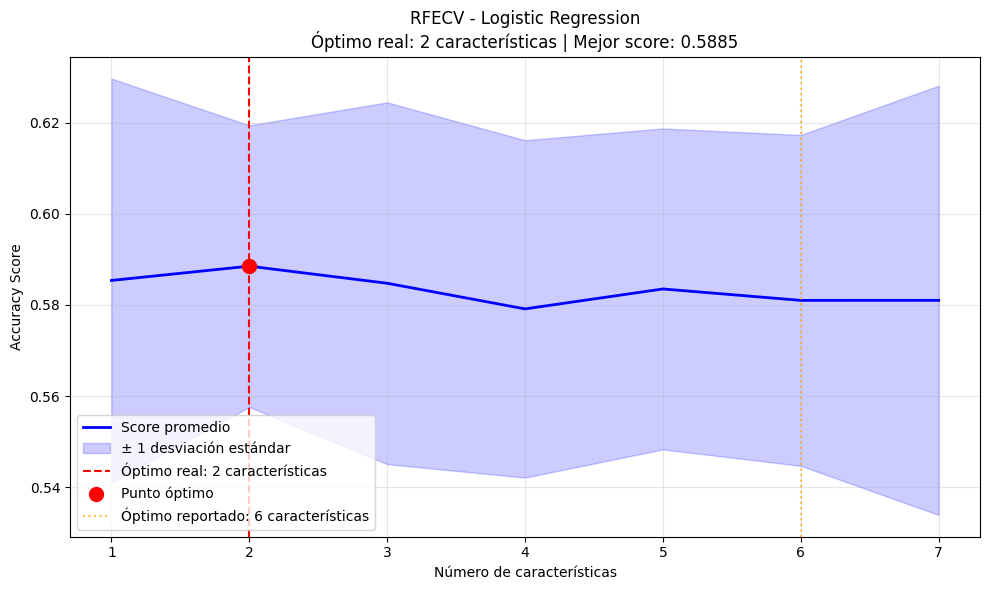

   ⚠️  Discrepancia: RFECV reporta 6 óptimas, pero el mejor score está en 2

🔍 Random Forest:
>>> Características totales: 11
>>> Puntos evaluados: 7
>>> Step usado: 1
>>> Número óptimo reportado: 5
>>> Número óptimo real: 1
>>> Mejor score de validación: 0.5741
>>> Características seleccionadas (5):
     1. volatile acidity
     2. total sulfur dioxide
     3. density
     4. sulphates
     5. alcohol
   📊 Debug: Óptimo reportado = 5, Puntos evaluados = 7


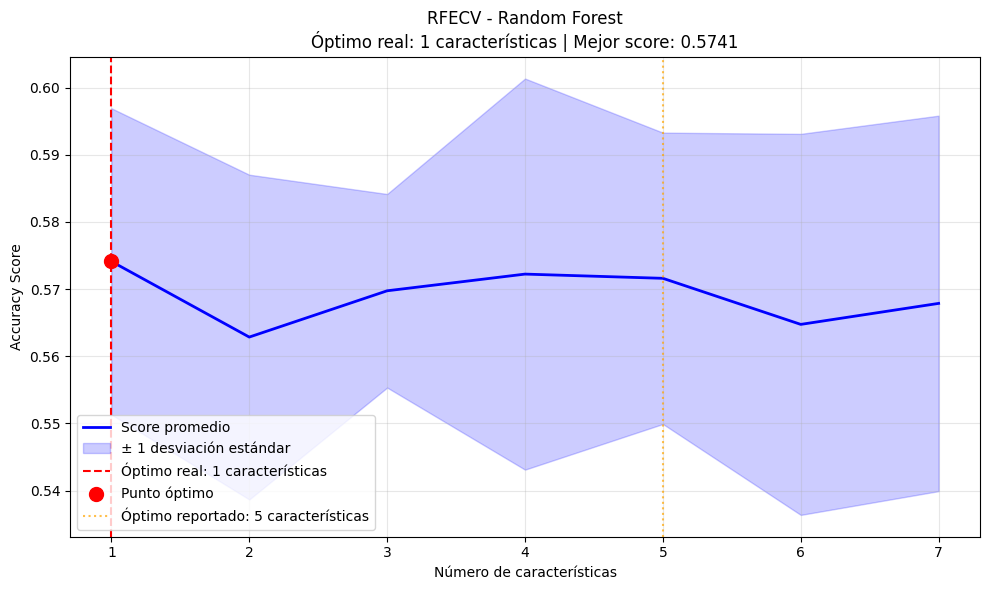

   ⚠️  Discrepancia: RFECV reporta 5 óptimas, pero el mejor score está en 1

🔍 Gradient Boosting:
>>> Características totales: 11
>>> Puntos evaluados: 7
>>> Step usado: 1
>>> Número óptimo reportado: 11
>>> Número óptimo real: 7
>>> Mejor score de validación: 0.5660
>>> Características seleccionadas (11):
     1. fixed acidity
     2. volatile acidity
     3. citric acid
     4. residual sugar
     5. chlorides
     6. free sulfur dioxide
     7. total sulfur dioxide
     8. density
     9. pH
     10. sulphates
     11. alcohol
   📊 Debug: Óptimo reportado = 11, Puntos evaluados = 7


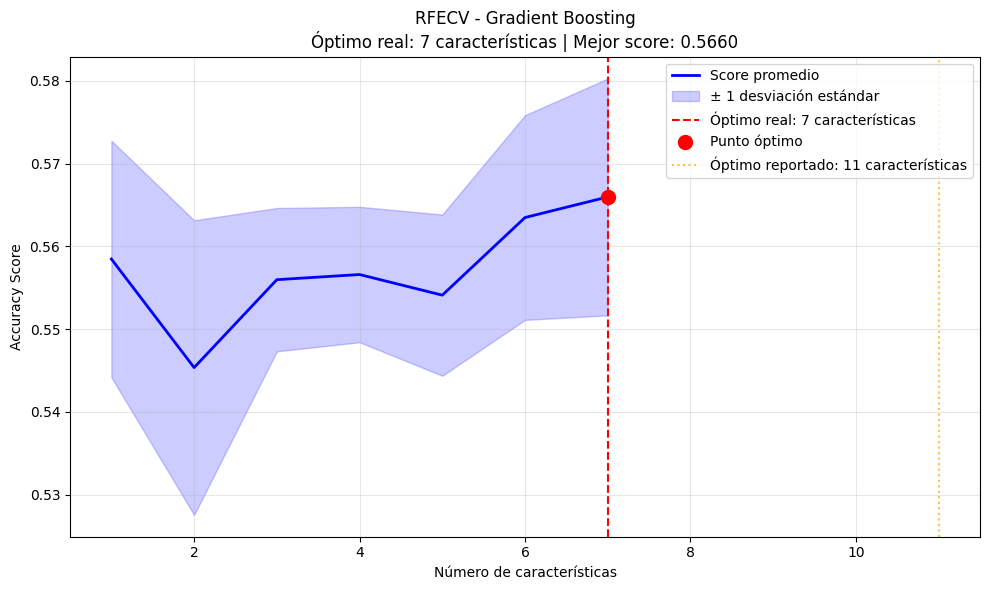

   ⚠️  Discrepancia: RFECV reporta 11 óptimas, pero el mejor score está en 7


In [17]:
for model_name, model in models.items():
    # Ejecutar RFECV
    resultados_rf = run_rfecv_analysis(
        model=model,
        model_name=model_name,
        X=X_scaled,  # Tus características escaladas
        y=y,         # Tu variable objetivo
        min_features=5,
        cv_folds=5
    )

    plot_rfecv_results(resultados_rf, X_scaled.columns)

**Forward Selection - Implementación Completa**


In [18]:
def run_forward_selection(model, model_name, X, y, n_features='auto', cv_folds=5, direction='forward'):
  
    print(f"\n{model_name} - Forward Selection:")
    
    try:
        # Si es 'auto', selecciona la mitad de las características
        if n_features == 'auto':
            n_features = max(1, X.shape[1] // 2)
        
        # Configurar Forward Selection
        sfs_forward = SequentialFeatureSelector(
            estimator=model,
            n_features_to_select=n_features,
            direction=direction,
            cv=StratifiedKFold(cv_folds),
            scoring='accuracy',
            n_jobs=-1
        )
        
        # Ajustar el selector
        sfs_forward.fit(X, y)
        
        # Obtener características seleccionadas
        selected_features = X.columns[sfs_forward.get_support()]
        feature_mask = sfs_forward.get_support()
        
        # Evaluar performance con las características seleccionadas
        X_selected = sfs_forward.transform(X)
        cv_scores = cross_val_score(model, X_selected, y, cv=cv_folds, scoring='accuracy')
        
        # Recopilar resultados
        results = {
            'model_name': model_name,
            'method': 'Forward Selection',
            'n_features_selected': len(selected_features),
            'selected_features': selected_features,
            'feature_mask': feature_mask,
            'mean_score': cv_scores.mean(),
            'std_score': cv_scores.std(),
            'cv_scores': cv_scores,
            'sfs_object': sfs_forward,
            'success': True
        }
        
        # Mostrar resultados
        print(f">>> Características seleccionadas: {results['n_features_selected']}")
        print(f">>> Score de validación: {results['mean_score']:.4f} ± {results['std_score']:.4f}")
        print(f">>> Características:")
        for i, feature in enumerate(results['selected_features'], 1):
            print(f"     {i}. {feature}")
            
        return results
        
    except Exception as e:
        error_msg = f"   ❌ Error con {model_name}: {e}"
        print(error_msg)
        return {
            'model_name': model_name,
            'method': 'Forward Selection',
            'success': False,
            'error': str(e)
        }

def plot_forward_selection_results(results, X_original):
    """
    Genera gráfico comparativo para Forward Selection
    """
    if not results['success']:
        return
    
    try:
        # Comparar performance vs todas las características
        model = results['sfs_object'].estimator
        all_features_score = cross_val_score(model, X_original, y, cv=5, scoring='accuracy')
        
        # Preparar datos para el gráfico
        methods = ['Todas las características', 'Forward Selection']
        scores = [all_features_score.mean(), results['mean_score']]
        errors = [all_features_score.std(), results['std_score']]
        
        # Crear gráfico de comparación
        plt.figure(figsize=(10, 6))
        bars = plt.bar(methods, scores, yerr=errors, capsize=10, 
                      color=['lightblue', 'lightgreen'], alpha=0.7)
        
        # Añadir valores en las barras
        for i, (score, error) in enumerate(zip(scores, errors)):
            plt.text(i, score + error + 0.01, f'{score:.4f} ± {error:.4f}', 
                    ha='center', va='bottom', fontweight='bold')
        
        plt.ylabel('Accuracy Score')
        plt.title(f'Forward Selection - {results["model_name"]}\n'
                 f'Reducción: {X_original.shape[1]} → {results["n_features_selected"]} características')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        print(f" Comparación:")
        print(f"      • Todas las características ({X_original.shape[1]}): {all_features_score.mean():.4f}")
        print(f"      • Forward Selection ({results['n_features_selected']}): {results['mean_score']:.4f}")
        print(f"      • Mejora: {results['mean_score'] - all_features_score.mean():+.4f}")
        
    except Exception as e:
        print(f"   Error al graficar {results['model_name']}: {e}")


Logistic Regression - Forward Selection:
>>> Características seleccionadas: 5
>>> Score de validación: 0.5985 ± 0.0363
>>> Características:
     1. volatile acidity
     2. chlorides
     3. total sulfur dioxide
     4. sulphates
     5. alcohol


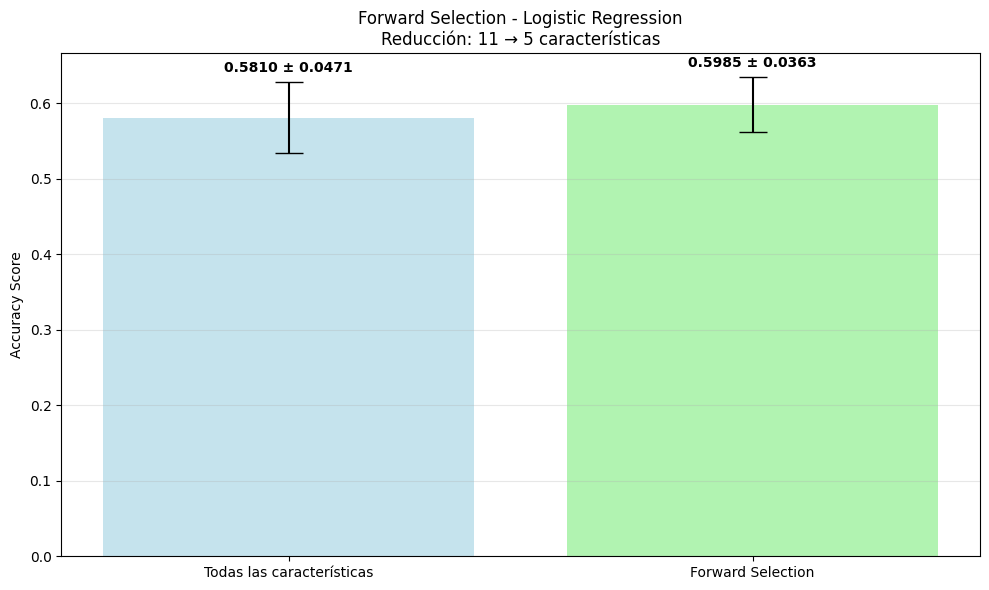

 Comparación:
      • Todas las características (11): 0.5810
      • Forward Selection (5): 0.5985
      • Mejora: +0.0175

Random Forest - Forward Selection:
>>> Características seleccionadas: 5
>>> Score de validación: 0.5797 ± 0.0160
>>> Características:
     1. residual sugar
     2. free sulfur dioxide
     3. total sulfur dioxide
     4. sulphates
     5. alcohol


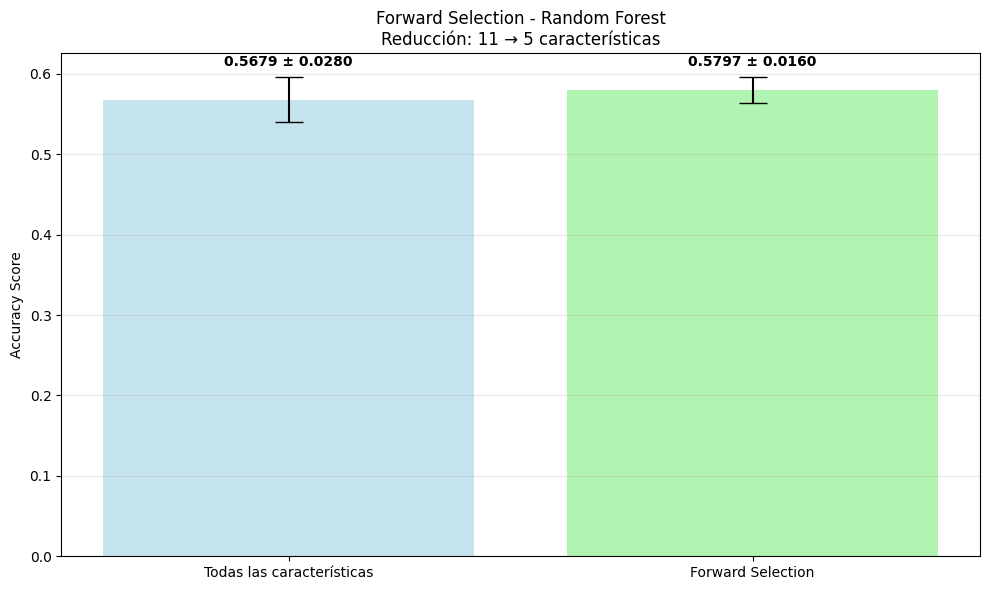

 Comparación:
      • Todas las características (11): 0.5679
      • Forward Selection (5): 0.5797
      • Mejora: +0.0119

Gradient Boosting - Forward Selection:
>>> Características seleccionadas: 5
>>> Score de validación: 0.5666 ± 0.0229
>>> Características:
     1. residual sugar
     2. free sulfur dioxide
     3. total sulfur dioxide
     4. sulphates
     5. alcohol


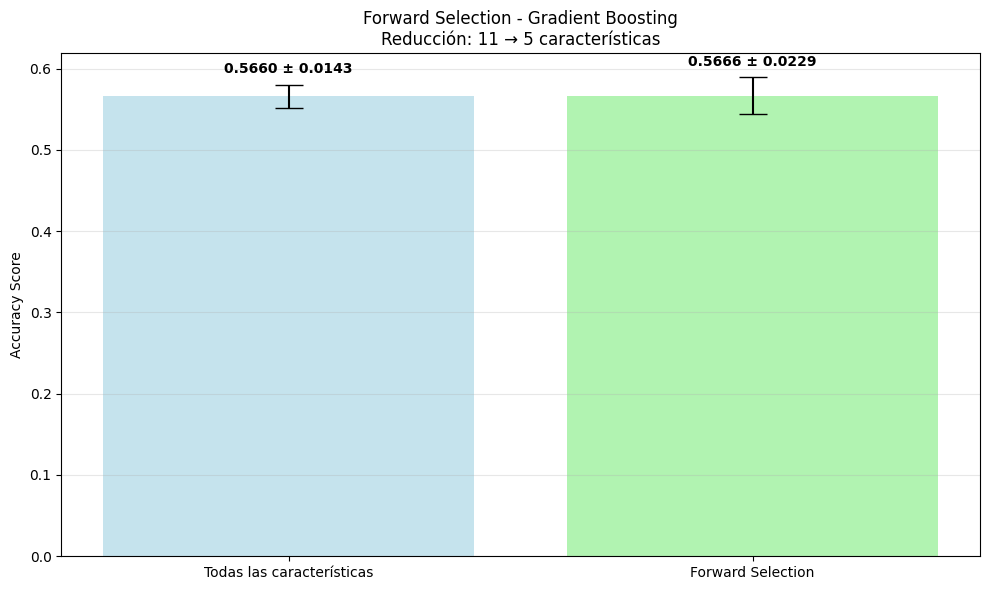

 Comparación:
      • Todas las características (11): 0.5660
      • Forward Selection (5): 0.5666
      • Mejora: +0.0006


In [19]:
for model_name, model in models.items():

    resultados = run_forward_selection(
        model=model,
        model_name=model_name,
        X=X_scaled,  # Tu DataFrame de características
        y=y,         # Tu variable objetivo
        n_features='auto',  # Selecciona automáticamente la mitad
        cv_folds=5
    )
        
    # Generar gráfico comparativo
    plot_forward_selection_results(resultados, X_scaled)

**Backward Elimination - Implementación Completa**


In [21]:
def run_backward_elimination(model, model_name, X, y, n_features='auto', cv_folds=5):

    print(f"\n{model_name} - Backward Elimination:")
    
    try:
        # Si es 'auto', selecciona la mitad de las características
        if n_features == 'auto':
            n_features = max(1, X.shape[1] // 2)
        
        # Configurar Backward Elimination
        sfs_backward = SequentialFeatureSelector(
            estimator=model,
            n_features_to_select=n_features,
            direction='backward',
            cv=StratifiedKFold(cv_folds),
            scoring='accuracy',
            n_jobs=-1
        )
        
        # Ajustar el selector
        sfs_backward.fit(X, y)
        
        # Obtener características seleccionadas
        selected_features = X.columns[sfs_backward.get_support()]
        feature_mask = sfs_backward.get_support()
        
        # Evaluar performance con las características seleccionadas
        X_selected = sfs_backward.transform(X)
        cv_scores = cross_val_score(model, X_selected, y, cv=cv_folds, scoring='accuracy')
        
        # Recopilar resultados
        results = {
            'model_name': model_name,
            'method': 'Backward Elimination',
            'n_features_selected': len(selected_features),
            'selected_features': selected_features,
            'feature_mask': feature_mask,
            'mean_score': cv_scores.mean(),
            'std_score': cv_scores.std(),
            'cv_scores': cv_scores,
            'sfs_object': sfs_backward,
            'success': True
        }
        
        # Mostrar resultados
        print(f">>> Características seleccionadas: {results['n_features_selected']}")
        print(f">>> Score de validación: {results['mean_score']:.4f} ± {results['std_score']:.4f}")
        print(f">>> Características:")
        for i, feature in enumerate(results['selected_features'], 1):
            print(f"     {i}. {feature}")
            
        return results
        
    except Exception as e:
        error_msg = f"   ❌ Error con {model_name}: {e}"
        print(error_msg)
        return {
            'model_name': model_name,
            'method': 'Backward Elimination',
            'success': False,
            'error': str(e)
        }

def plot_backward_elimination_results(results, X_original):

    if not results['success']:
        return
    
    try:
        # Comparar performance vs todas las características
        model = results['sfs_object'].estimator
        all_features_score = cross_val_score(model, X_original, y, cv=5, scoring='accuracy')
        
        # Preparar datos para el gráfico
        methods = ['Todas las características', 'Backward Elimination']
        scores = [all_features_score.mean(), results['mean_score']]
        errors = [all_features_score.std(), results['std_score']]
        
        # Crear gráfico de comparación
        plt.figure(figsize=(10, 6))
        bars = plt.bar(methods, scores, yerr=errors, capsize=10, 
                      color=['lightblue', 'lightcoral'], alpha=0.7)
        
        # Añadir valores en las barras
        for i, (score, error) in enumerate(zip(scores, errors)):
            plt.text(i, score + error + 0.01, f'{score:.4f} ± {error:.4f}', 
                    ha='center', va='bottom', fontweight='bold')
        
        plt.ylabel('Accuracy Score')
        plt.title(f'Backward Elimination - {results["model_name"]}\n'
                 f'Reducción: {X_original.shape[1]} → {results["n_features_selected"]} características')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        print(f" Comparación:")
        print(f"      • Todas las características ({X_original.shape[1]}): {all_features_score.mean():.4f}")
        print(f"      • Backward Elimination ({results['n_features_selected']}): {results['mean_score']:.4f}")
        print(f"      • Mejora: {results['mean_score'] - all_features_score.mean():+.4f}")
        
    except Exception as e:
        print(f"  Error al graficar {results['model_name']}: {e}")


Logistic Regression - Backward Elimination:
>>> Características seleccionadas: 5
>>> Score de validación: 0.5935 ± 0.0384
>>> Características:
     1. volatile acidity
     2. chlorides
     3. total sulfur dioxide
     4. sulphates
     5. alcohol


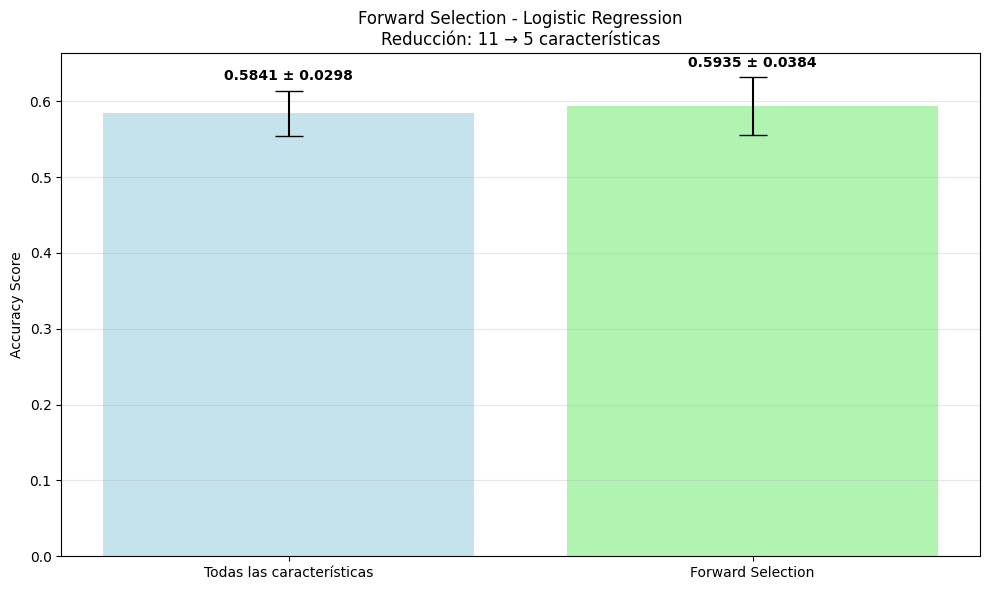

 Comparación:
      • Todas las características (11): 0.5841
      • Forward Selection (5): 0.5935
      • Mejora: +0.0094

Random Forest - Backward Elimination:
>>> Características seleccionadas: 5
>>> Score de validación: 0.5879 ± 0.0192
>>> Características:
     1. fixed acidity
     2. volatile acidity
     3. total sulfur dioxide
     4. sulphates
     5. alcohol


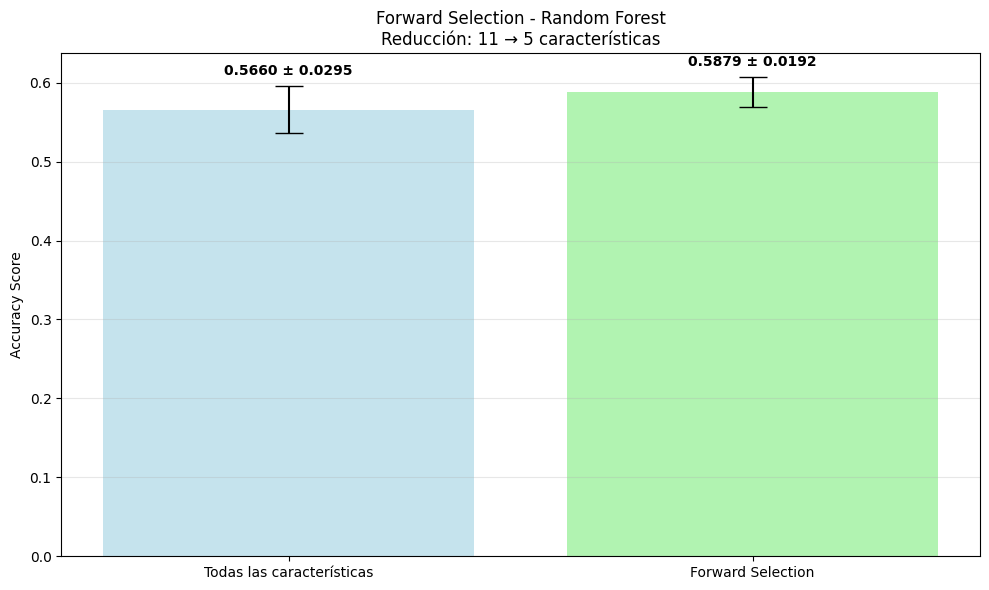

 Comparación:
      • Todas las características (11): 0.5660
      • Forward Selection (5): 0.5879
      • Mejora: +0.0219

Gradient Boosting - Backward Elimination:
>>> Características seleccionadas: 5
>>> Score de validación: 0.5597 ± 0.0212
>>> Características:
     1. chlorides
     2. total sulfur dioxide
     3. pH
     4. sulphates
     5. alcohol


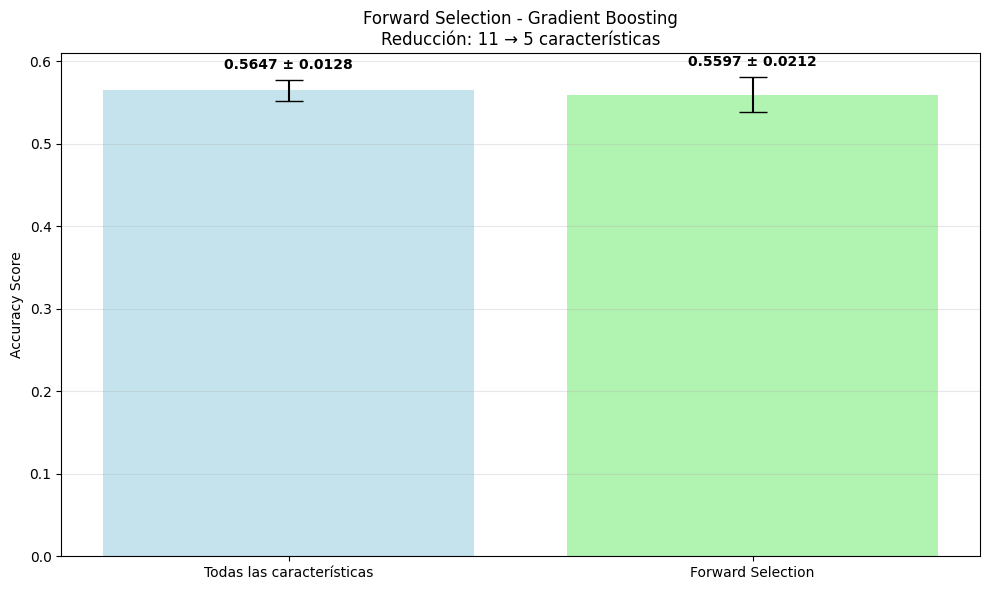

 Comparación:
      • Todas las características (11): 0.5647
      • Forward Selection (5): 0.5597
      • Mejora: -0.0050


In [22]:
for model_name, model in models.items():
    resultados = run_backward_elimination(
        model=model,
        model_name=model_name,
        X=X,
        y=y
    )
    
    
    plot_forward_selection_results(resultados, X)
    